In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader, DataListLoader
import IPython.display
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

from utils.load_data import BatchData
from utils import summary

USE_GPU = True
HIDDEN_CHANNELS = 6
LATENT_DIMS =   2
MAX_LOGSTD = 10

device = torch.device("cuda")

/home/maximus/anaconda3/envs/gnn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Encoder(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, latent_dims):
        super(Encoder, self).__init__()
        # self.linear = torch.nn.Linear(num_node_features, hidden_channels)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2 * latent_dims)
        self.conv_mu = GCNConv(2 * latent_dims, latent_dims)
        self.conv_logstd = GCNConv(2 * latent_dims, latent_dims)

    def forward(self, x, edge_index):
    # Linear transformation
        # x = self.linear(x)
        # x = F.relu(x)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [3]:
class Decoder(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, latent_dims):
        super(Decoder, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(latent_dims, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, num_node_features)
        )

    def forward(self, z, edge_index):
        # Compute node embeddings
        z = self.mlp(z)
        # Compute probability of edge existence
        prob = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        prob = torch.sigmoid(prob)
        return prob

In [4]:
class VariationalAutoencoder(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super(VariationalAutoencoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.mu = None
    self.sigma = None
  
  def reparametrize(self):
    return self.mu + torch.randn_like(self.sigma) * torch.exp(self.sigma)

  def forward(self, x, edge_index):
    # Apply the MLP to the feature vectors
    self.mu, self.sigma = self.encoder(x, edge_index)
    self.sigma = self.sigma.clamp(max=MAX_LOGSTD)
    z = self.reparametrize()
    # Apply the GNN to the graph and feature vectors
    pred = self.decoder(z, edge_index)
    return pred
  
  def kl_loss(self):
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * self.sigma - self.mu**2 - self.sigma.exp()**2, dim=1))

In [5]:
def displayStats(loader):
        for batch in loader:
            print(batch)
            data = batch[0] # Get the first graph object.
            print(data)
            print('==============================================================')
            # Gather some statistics about the graph.
            print(f'Number of nodes: {data.num_nodes}')
            print(f'Number of edges: {data.num_edges}')
            print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
            print(f'Number of node features: {data.num_features}')
            print(f'Number of edge features: {data.edge_attr.shape[1]}')
            # print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
            print(f'Has isolated nodes: {data.has_isolated_nodes()}')
            print(f'Has self-loops: {data.has_self_loops()}')
            print(f'Is undirected: {data.is_undirected()}')
            break
        return None

def test_visualise(graph):
    g = torch_geometric.utils.to_networkx(graph, to_undirected=True)
    nx.draw_networkx(g)
    plt.show()
    return None

def getDataDims(loader):
    return [loader.dataset[0].num_features, loader.dataset[0].edge_attr.shape[1]]


In [6]:
def train_model(model, loader_train, loader_test, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_history =[]
    roc_history =[]
    ap_history =[]


    for epoch in range(num_epochs):
        for batch in loader_train:
            if(USE_GPU):
                x           = batch["x"].to("cuda")
                edge_index  = batch["edge_index"].to("cuda")
                edge_attr   = batch["edge_attr"].to("cuda")
                y           = batch["y"].to("cuda")
            probs = model.forward(x, edge_index)
            loss = F.binary_cross_entropy(probs, y) + ((1 / batch.num_nodes) * model.kl_loss())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            roc_auc, ap = test(model, loader_test)
            
        loss_history.append(float(loss.item()))
        roc_history.append(roc_auc)
        ap_history.append(ap)    
        if(epoch%1==0):
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, ROC Score: {roc_auc:.4f}, AP Score: {ap:.4f}")
        del loss
        del probs    
        torch.cuda.empty_cache()
    return loss_history, roc_history, ap_history

def test(model, loader):
    for batch in loader:
        if(USE_GPU):
            x           = batch["x"].to("cuda")
            edge_index  = batch["edge_index"].to("cuda")
            edge_attr   = batch["edge_attr"].to("cuda")
            y           = batch["y"].to("cuda")
        probs = model.forward(x, edge_index)
    y, pred = y.detach().cpu().numpy(), probs.detach().cpu().numpy()

    return roc_auc_score(y, pred), average_precision_score(y, pred)
    

In [7]:
def init_model(num_nf, num_hidden_channels, latent_dims, loader):
    encoder = Encoder(num_nf, num_hidden_channels, latent_dims)
    decoder = Decoder(num_nf, num_hidden_channels, latent_dims)
    model = VariationalAutoencoder(encoder, decoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    print(summary.summary(model, loader.dataset[0]["x"], loader.dataset[0]["edge_index"]))
    return model

In [8]:
## TODO: Change to DataListLoader to allow batches to be subscriptable and possibly add functionality for parallelisation

## TODO: init BatchData with an index range instead to allow 80 20 train-test split

loader_train = DataLoader(BatchData(0,8), batch_size=64, pin_memory=True, num_workers=4)
print("Train Set Batch Count:", len(loader_train))
displayStats(loader=loader_train)
loader_test = DataLoader(BatchData(8,10), batch_size=16, pin_memory=True, num_workers=4)
print("Test Set Batch Count:", len(loader_train))
displayStats(loader=loader_test)
num_nf, num_ef = getDataDims(loader=loader_train)


Loading:
../data/batch_1_0
../data/batch_1_1
../data/batch_1_2
../data/batch_1_3
../data/batch_1_4
../data/batch_1_5
../data/batch_1_6
../data/batch_1_7
Train Set Batch Count: 125
DataBatch(x=[19402, 6], edge_index=[2, 250624], edge_attr=[250624, 4], y=[250624], batch=[19402], ptr=[65])
Data(x=[350, 6], edge_index=[2, 8138], edge_attr=[8138, 4], y=[8138])
Number of nodes: 350
Number of edges: 8138
Average node degree: 23.25
Number of node features: 6
Number of edge features: 4
Has isolated nodes: True
Has self-loops: False
Is undirected: False
Loading:
../data/batch_1_8
../data/batch_1_9
Test Set Batch Count: 125
DataBatch(x=[4587, 6], edge_index=[2, 60020], edge_attr=[60020, 4], y=[60020], batch=[4587], ptr=[17])
Data(x=[228, 6], edge_index=[2, 2094], edge_attr=[2094, 4], y=[2094])
Number of nodes: 228
Number of edges: 2094
Average node degree: 9.18
Number of node features: 6
Number of edge features: 4
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [9]:
model = init_model(num_nf, HIDDEN_CHANNELS, LATENT_DIMS, loader_train)

+-----------------------------+---------------------+--------------------+----------+
| Layer                       | Input Shape         | Output Shape       | #Param   |
|-----------------------------+---------------------+--------------------+----------|
| VariationalAutoencoder      | [350, 6], [2, 8138] | [8138]             | 150      |
| ├─(encoder)Encoder          | [350, 6], [2, 8138] | [350, 2], [350, 2] | 90       |
| │    └─(conv1)GCNConv       | [350, 6], [2, 8138] | [350, 6]           | 42       |
| │    └─(conv2)GCNConv       | [350, 6], [2, 8138] | [350, 4]           | 28       |
| │    └─(conv_mu)GCNConv     | [350, 4], [2, 8138] | [350, 2]           | 10       |
| │    └─(conv_logstd)GCNConv | [350, 4], [2, 8138] | [350, 2]           | 10       |
| ├─(decoder)Decoder          | [350, 2], [2, 8138] | [8138]             | 60       |
| │    └─(mlp)Sequential      | [350, 2]            | [350, 6]           | 60       |
| │    │    └─(0)Linear       | [350, 2]            | 

In [10]:
if(USE_GPU):
    model.to(device = "cuda")
    torch.cuda.empty_cache()

print("Training on GPU:", next(model.parameters()).is_cuda)
loss_hist, roc_hist, ap_hist = train_model(model, loader_train, loader_test, num_epochs = 25)

Training on GPU: True
Epoch 0, Loss: 0.6909, ROC Score: 0.5870, AP Score: 0.2460
Epoch 1, Loss: 0.5177, ROC Score: 0.7737, AP Score: 0.5226
Epoch 2, Loss: 0.5723, ROC Score: 0.7898, AP Score: 0.5580
Epoch 3, Loss: 0.5590, ROC Score: 0.7932, AP Score: 0.5620
Epoch 4, Loss: 0.5308, ROC Score: 0.7935, AP Score: 0.5595
Epoch 5, Loss: 0.5250, ROC Score: 0.7953, AP Score: 0.5612
Epoch 6, Loss: 0.5217, ROC Score: 0.7959, AP Score: 0.5631
Epoch 7, Loss: 0.5078, ROC Score: 0.7957, AP Score: 0.5569
Epoch 8, Loss: 0.4176, ROC Score: 0.8042, AP Score: 0.5750
Epoch 9, Loss: 0.3562, ROC Score: 0.8253, AP Score: 0.6204
Epoch 10, Loss: 0.3618, ROC Score: 0.8270, AP Score: 0.6229
Epoch 11, Loss: 0.3514, ROC Score: 0.8282, AP Score: 0.6274
Epoch 12, Loss: 0.3430, ROC Score: 0.8334, AP Score: 0.6453
Epoch 13, Loss: 0.3309, ROC Score: 0.8429, AP Score: 0.6692
Epoch 14, Loss: 0.3234, ROC Score: 0.8445, AP Score: 0.6783
Epoch 15, Loss: 0.3167, ROC Score: 0.8463, AP Score: 0.6975
Epoch 16, Loss: 0.3103, ROC 

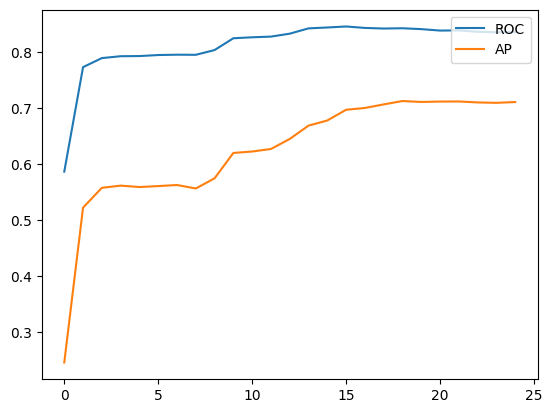

In [11]:

plt.plot(roc_hist, label="ROC")
plt.plot(ap_hist, label="AP")
plt.legend(loc="upper right")
plt.show()

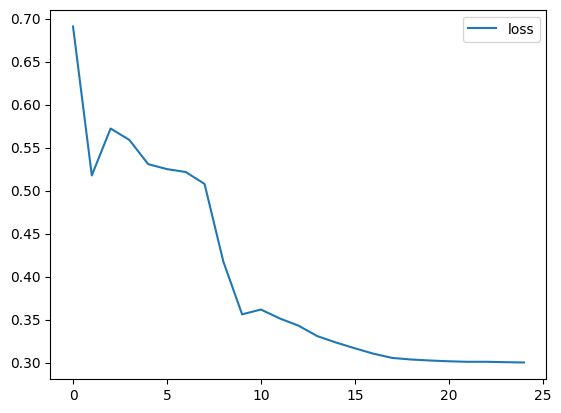

In [12]:
plt.plot(loss_hist, label="loss")
plt.legend()
plt.show()
roc_auc, ap = test(model, loader_test)

In [13]:
print("ROC:{}%".format(roc_auc*100))
print("Average Precision:{}%".format(ap*100))

ROC:83.63346489509549%
Average Precision:71.1218555366607%
